<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Sandun-Karunatilleke/ARIMA_and_SARIMA_for_MAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Mounting the Drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')
# '/content/drive/MyDrive/Datasets/preprocessed_data_new.xlsx'
# Load preprocessed data from Excel file
#file_path = '/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx'
file_path = '/content/drive/MyDrive/Datasets/preprocessed_data_new.xlsx'
# file_path = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx'
data = pd.read_excel(file_path)
data


MessageError: Error: credential propagation was unsuccessful

In [3]:
# Specify the file path
!ls -l $file_path
file_path = 'preprocessed_data_new.xlsx'

data = pd.read_excel(file_path)

total 3812
-rw-r--r-- 1 root root 3896494 Apr  5 09:07 preprocessed_data_new.xlsx
drwxr-xr-x 1 root root    4096 Apr  3 13:25 sample_data


### EDA

In [4]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'MAT': [sub_dept for sub_dept in data['Department'] if sub_dept.startswith('Team - MAT')]
}



# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
data['MainDepartment'] = data['Department'].map(main_dept_for_sub_dept)


In [5]:
# Summarize total absence by main department
total_absence_by_main_dept = data.groupby(['LeaveYear','LeaveMonth','MainDepartment']).size().reset_index(name='totalAbsence')

#total_absence_by_main_dept.drop(17, inplace=True)
total_absence_by_main_dept

,LeaveYear,LeaveMonth,MainDepartment,totalAbsence
0,2021,12,MAT,203
1,2022,1,MAT,127
2,2022,2,MAT,158
3,2022,3,MAT,235
4,2022,4,MAT,107
5,2022,5,MAT,175
6,2022,6,MAT,139
7,2022,7,MAT,147
8,2022,8,MAT,100
9,2022,9,MAT,79


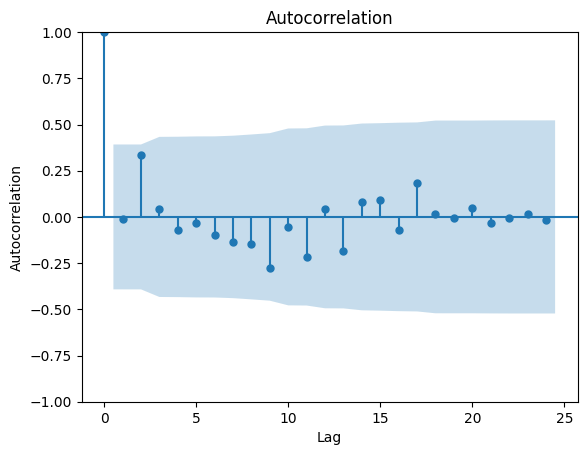

In [6]:
# Plot ACF
plot_acf(total_absence_by_main_dept['totalAbsence'], lags=24)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

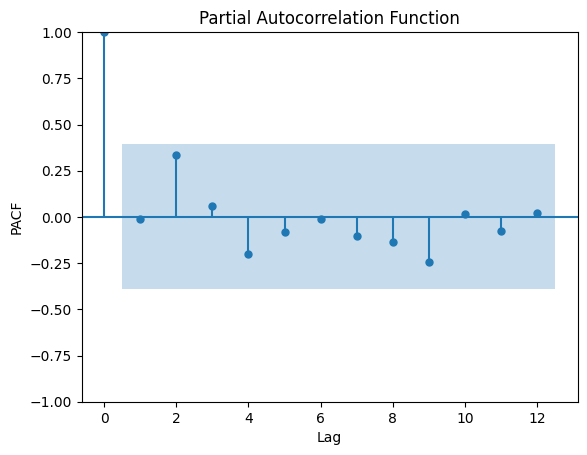

In [7]:
# Plot partial autocorrelation function
plot_pacf(total_absence_by_main_dept['totalAbsence'])
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

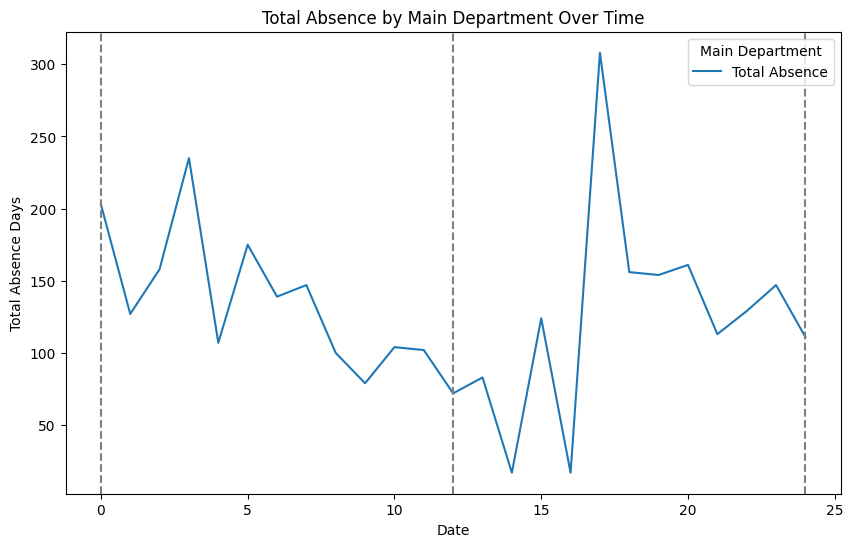

In [8]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'], label='Total Absence')

# Adding dotted lines at 5-day intervals
for i in range(0, len(total_absence_by_main_dept),12):
    plt.axvline(x=i, color='gray', linestyle='--')

plt.title('Total Absence by Main Department Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence Days')
plt.legend(title='Main Department')
plt.show()


### ADF Test

In [9]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### Splitting Data

In [10]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.8)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]

### ARIMA Model

### Evaluating Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE :  2777.706790536819
RSME :  52.703954221071676


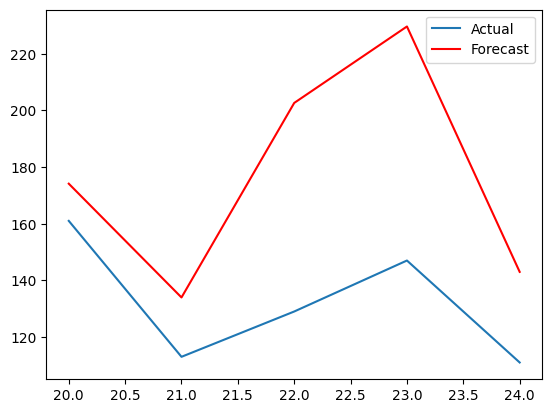

In [11]:
# Fit ARIMA model for each main department
model = ARIMA(train, order=(1,1,10))
model_fit = model.fit()

#print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
#print(forecast)

mse = mean_squared_error(test, forecast)
print("MSE : ", mse)

rsme = np.sqrt(mse)
print("RSME : ", rsme)

plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.show()



## ADF Test

In [12]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


## Splitting Data

In [13]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.9)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]


## EDA

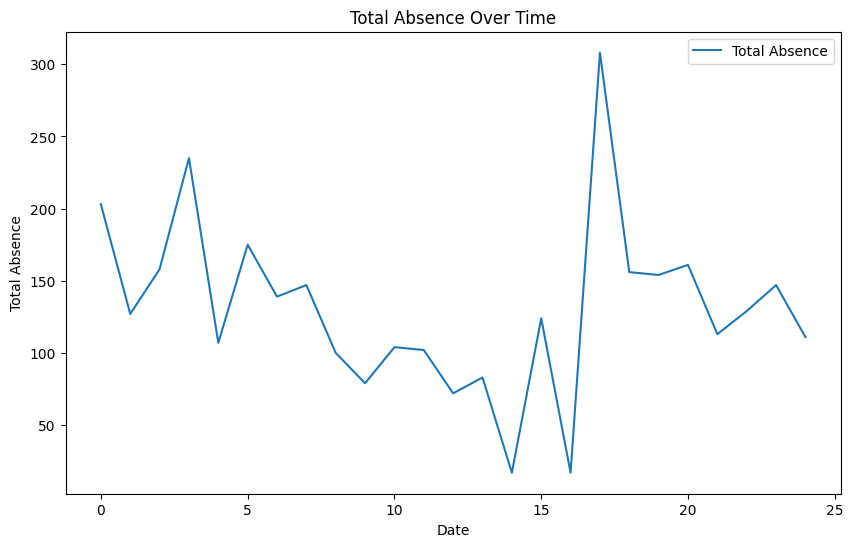

Descriptive Statistics:
count     25.000000
mean     130.720000
std       61.577539
min       17.000000
25%      102.000000
50%      127.000000
75%      156.000000
max      308.000000
Name: totalAbsence, dtype: float64


In [14]:
# EDA
# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'], label='Total Absence')
plt.title('Total Absence Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence')
plt.legend()

plt.show()

# Descriptive Statistics
print("Descriptive Statistics:")
print(total_absence_by_main_dept['totalAbsence'].describe())

## SARIMA Model


In [73]:
# SARIMA modeling (continued from original code)
order = (0, 1, 1)  # Non-seasonal parameters
seasonal_order = (1, 1, 1, 6)  # Seasonal parameters, here assuming a yearly seasonal pattern

# Fit SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test))
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


22     98.930622
23    144.102832
24    111.567148
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
# import pickle

# # Save the model to a file
# file_path = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Models/Mat_sarimax.pkl'
# with open(file_path, 'wb') as f:
#     pickle.dump(model_fit, f)


### Evaluating the *Model*

MSE: 304.294240711934
RMSE: 17.444031664495853


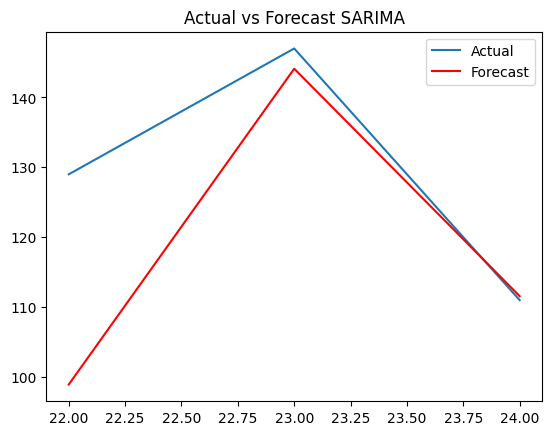

                                     SARIMAX Results                                     
Dep. Variable:                      totalAbsence   No. Observations:                   22
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 -87.944
Date:                           Fri, 05 Apr 2024   AIC                            183.889
Time:                                   09:39:16   BIC                            186.721
Sample:                                        0   HQIC                           183.859
                                            - 22                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5867      0.714     -0.822      0.411      -1.986       0.812
ar.S.L6       -0.3530      1.541     -0.229

In [74]:
# Calculate MSE and RMSE
mse = mean_squared_error(test, forecast)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Visualize actual vs forecast
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title('Actual vs Forecast SARIMA')
plt.show()

print(model_fit.summary())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

order = (1, 1, 0)  # Non-seasonal parameters
seasonal_order = (1, 0, 2, 10)  # Seasonal parameters, here assuming a yearly seasonal pattern

# Function to evaluate ARIMA model
def evaluate_arima(train, test, order):
    # Fit ARIMA model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Calculate MSE and RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    return forecast, mse, rmse

# Function to evaluate ETS model
def evaluate_ets(train, test, seasonal_periods):
    # Fit ETS model
    model = ExponentialSmoothing(train)
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Calculate MSE and RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    return forecast, mse, rmse

# Function to evaluate SARIMA model
def evaluate_sarima(train, test, order, seasonal_order):
    # Fit SARIMA model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=len(test))

    # Calculate MSE and RMSE
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)

    return forecast, mse, rmse

# Split data into train and test sets
train = total_absence_by_main_dept['totalAbsence'].iloc[:train_size]
test = total_absence_by_main_dept['totalAbsence'].iloc[train_size:]

# Evaluate ARIMA model
arima_forecast, arima_mse, arima_rmse = evaluate_arima(train, test, order)

# Evaluate ETS model
seasonal_periods = 12
ets_forecast, ets_mse, ets_rmse = evaluate_ets(train, test, seasonal_periods)

# Evaluate SARIMA model
sarima_forecast, sarima_mse, sarima_rmse = evaluate_sarima(train, test, order, seasonal_order)


# Displaying the MSE and RMSE for each model
print("ARIMA Model:")
print("MSE:", arima_mse)
print("RMSE:", arima_rmse)
print()

print("ETS (Exponential Smoothing) Model:")
print("MSE:", ets_mse)
print("RMSE:", ets_rmse)
print()

print("SARIMA Model:")
print("MSE:", sarima_mse)
print("RMSE:", sarima_rmse)
print()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA Model:
MSE: 493.3383806138066
RMSE: 22.211221952288142

ETS (Exponential Smoothing) Model:
MSE: 216.2678275754705
RMSE: 14.706047313111382

SARIMA Model:
MSE: 181.2529639441186
RMSE: 13.46302209550733



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


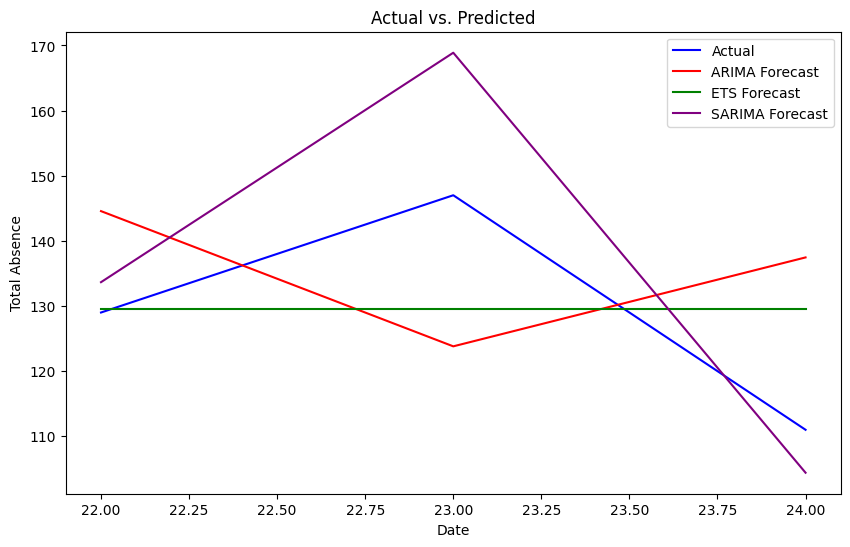

In [ ]:
# Plotting actual vs. predicted values for all models
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, label='Actual', color='blue')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.plot(test.index, ets_forecast, label='ETS Forecast', color='green')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='purple')
plt.title('Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Total Absence')
plt.legend()
plt.show()